In [69]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
#read in all the words in dict
words = open('names.txt', 'r').read().splitlines()
words[:8]
len(words)

32033

In [71]:
#build character vocabulary and mappings from/to integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [72]:
#build the dataset
block_size = 3 # length of context: how many characters needed to predict the next one?
def build_database(words):
    X,Y = [],[]
    for w in words:
        #print(w)
        context = [0] * block_size 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) #80 percent length mark
n2 = int(0.9*len(words)) #90 percent length mark

Xtr, Ytr = build_database(words[:n1]) #training set
Xdev, Ydev = build_database(words[n1:n2]) #dev set
Xte, Yte = build_database(words[n2:]) #testing set
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [73]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
#For Kaiming Scaling, we need to multiply by gain and divide by fan_in
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

#Introduce gain and bias for scaling and shifting of normalized inputs
bnorm_gain = torch.ones((1, n_hidden))
bnorm_bias = torch.zeros((1, n_hidden))
#we want mean to be close to zero and std to be close to one
running_mean = torch.zeros((1,n_hidden))
running_std = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bnorm_gain, bnorm_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [74]:
# h = torch.tanh(emb.view(-1,6) @ W1 + b1) #when inputting -1, pytorch will infer the dimmension

In [75]:
#concatenate embeddings for all inputs
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape

In [76]:
# h

In [77]:
learning_rate_exponent = torch.linspace(-3,0,1000)
lrs = 10**learning_rate_exponent #create learning rates between -0.001 and -1
lrs[:50] #exponentially stepped between these rates, rather than linearly

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014])

In [78]:
max_steps = 200000
batch_size = 32
lossi = [] 

In [79]:
#optimization
for i in range(max_steps):
    #construct mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix] #batch X,Y

    #forward pass 
    emb = C[Xb] #character embeddings into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate vectors, -1 infers shape
    hpreact = embcat @ W1 #+ b1 #hidden layer before activation
    #b1 will not learn in this case, as it is subtracted with the norm
    #Normalize hpreact by subtracting mean, dividing by std
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bnorm_gain * (hpreact - running_mean) / running_std * bnorm_bias #norm bias used to bias distribution
    

    #keep running batch mean and batch std deviation
    with torch.no_grad():
        #will remain almost the same, with small update in direction of batch mean/std
        running_mean = 0.999 * running_mean + 0.001 * bnmeani
        running_std = 0.999 * running_std + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits,Yb) #calculate loss

    #backward pass
    for p in parameters:
        p.grad = None #reset gradient
    loss.backward()

    #update gradient based on lr
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data+= -lr * p.grad

    #track statistics
    if i % 10000 == 0: #print every 1000
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2958
  10000/ 200000: 2.1395
  20000/ 200000: 2.5863
  30000/ 200000: 2.0433
  40000/ 200000: 2.3793
  50000/ 200000: 1.9009
  60000/ 200000: 2.1429
  70000/ 200000: 2.2533
  80000/ 200000: 2.5326
  90000/ 200000: 2.2481
 100000/ 200000: 2.3001
 110000/ 200000: 2.4104
 120000/ 200000: 1.8182
 130000/ 200000: 2.0439
 140000/ 200000: 2.2997
 150000/ 200000: 2.0822
 160000/ 200000: 2.0554
 170000/ 200000: 2.5150
 180000/ 200000: 2.2620
 190000/ 200000: 2.1607


In [80]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [81]:
bnmean

tensor([[ 7.1686e+00, -1.4600e+00,  3.1136e+01, -1.1940e+01,  2.6023e-01,
          3.0143e+00,  7.0722e+01, -8.1373e+00,  1.1141e+01,  7.5658e+00,
         -6.5950e+00, -1.4789e+02, -3.2389e+00,  4.5475e-01, -1.5136e+00,
          6.2629e+00,  7.1781e-01, -8.5139e+01, -5.1849e+00,  5.1607e+01,
          4.5455e+00, -6.4298e+00, -8.4137e-01, -3.0054e+01,  6.4144e+01,
          8.4936e+01,  5.2586e+00, -3.8224e+00, -1.0236e+02,  9.7375e-01,
         -2.4581e+00, -3.8350e+00, -3.6212e+00,  9.5164e-01,  1.1177e+00,
          5.1588e+00,  9.2274e+01, -3.2164e+00, -3.2752e+01, -1.5547e+00,
         -1.9083e+01, -5.0761e+00, -6.5362e+00,  3.7543e+00,  2.7059e+00,
          9.3789e-01,  3.5585e+00,  1.1697e+02,  5.5725e+00,  3.2216e+00,
          2.1214e+00, -2.6519e-01, -9.0203e-01,  5.4443e+00, -3.5735e+00,
         -4.9190e+00,  6.0084e-02,  4.7191e+00,  2.5355e+00,  4.3475e+01,
         -9.9851e+01,  1.4383e+01, -2.9488e-01,  3.2404e-01, -4.7664e+00,
          1.3180e+02,  7.0342e+00,  2.

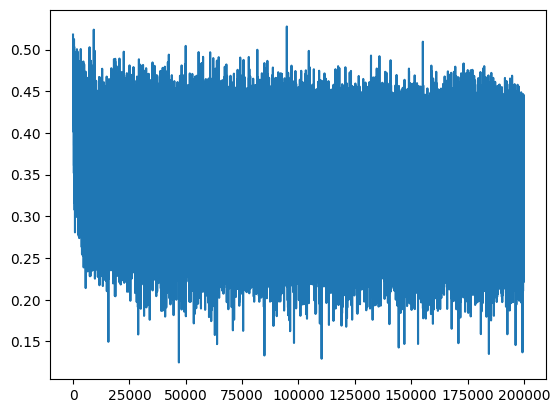

In [82]:
plt.plot(lossi)

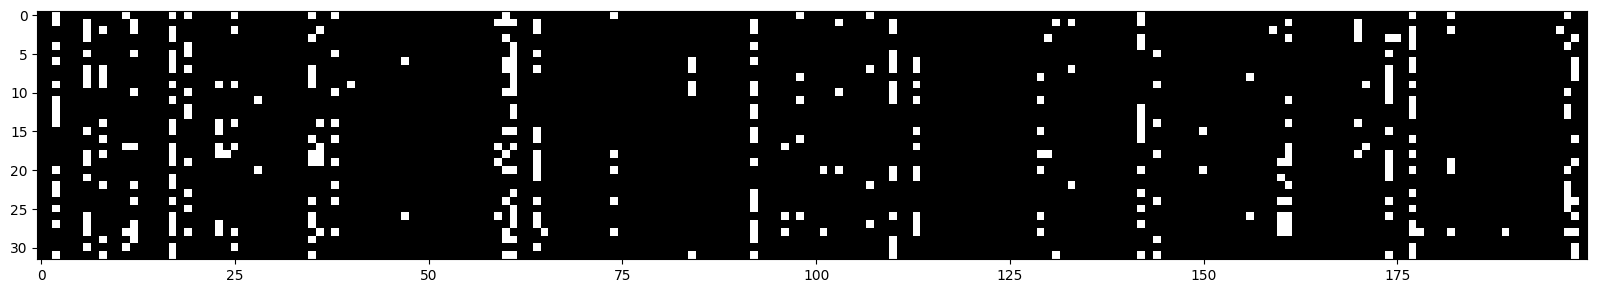

In [83]:
plt.figure(figsize=(20,10)) #visualize the activation of the tanh
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')
#if plot was all white, this would represent a dead nueron

In [84]:
#calibrate batch norm at the end of training
with torch.no_grad():
    #pass entire set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure mean/std over entire set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [85]:
@torch.no_grad() #disables gradient tracking for speed
def split_loss(split):
    x,y = {
        'train': [Xtr,Ytr],
        'val': [Xdev,Ydev],
        'test': [Xte,Yte],
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    # hpreact = bnorm_gain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) * bnorm_bias
    hpreact = bnorm_gain * (hpreact - bnmean) / bnstd * bnorm_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1865181922912598
val 2.198650360107422


In [86]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass nueral net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we get the end token, meaning end of word, break
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

choeahoqaothosahcennsacehocanscacskosanhnenaehnsahc.
hoqeecoeaonoacceachosaxnhonsehnnoooceceexnnasoocoeaceanoscocoecocaeahoxexckxecconsaccescecocacetneehnsaccohoaceonacccsyaxonaaosoosoncocenoocaceaeoeeensaonnuoceoececconaaouoneeaookehonoaae.
xonoeooceesneaon.
toeeneotonansoscoeanncossaocokocenaaconanahokcesneskanseosaececcnnoaaoccooocoaootoonaonooococacsoccense.
nu.
eoaoonnoeaosceaxotooscaxhoetecaconseccenoohnoccnsooscacocohoeocaeeseocensaccnnoaoohtecieensoonoaosoonteesceseenans.
nuncnvuhonoaaosaosaokcennttoscesonaoooacehotceneecocaaecocecoceheocacese.
honcocacnkacosoooaooheasooccnececknansonanshoaesoonneeexneooooeaecceacajnteceeocaanehoeonxocteonocoxoeooocetcesactcnneexnoacocensuesneaesaotkosnoncac.
honceaoneasonhex.
nanouosoexexcenooococaesonoeoncoshnhoxooxoxonsesaotehctanstoaatxtcnsaocacoknnoaosnooaoocanatoneaxosaocesceanahotaseonnoeceasee.
soecoeseoeccosocxonaosoacehooonoeosoncxaee.
aeucoconqsseanahanotceasaeccokooeehnoscetoceocenhesooococogaehhosceancoosoon.
hokxekoccnnoaocconeasn

In [111]:
# Deeper Network
#linear module
class Linear:
    #input features, output features, bias
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in, fan_out), generator=g) / fan_in**0.5 #kaiming scaling
        self.bias = torch.zeros(fan_out) if bias else None
    #calculate Wx + b 
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    #return tensor params of layer
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# batch norm module
class BatchNorm1d:
    
    #dimmensionality, epsilon, and momentum for running mean/variance
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps #epsilon to prevent division by zero during normalization
        self.momentum = momentum #control updates of mean/variance
        self.training = True 

        #parameters (learned with backprop)
        self.gamma = torch.zeros(dim)
        self.beta = torch.ones(dim)

        #buffers (learning with momentum update)
        #training using exponential average explicity, not part of DAG
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True,unbiased=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/ torch.sqrt(xvar+self.eps) #normalize to unit variance
        #create out for easy viewing of statistics
        self.out = self.gamma * xhat + self.beta 
        #update buffers if training
        if self.training:
            with torch.no_grad(): #no gradient for buffers
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta] #dont return mean and variance

#Non-linearity - Tanh Module
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 #dimmensions of the embedding vectors that are mapped from characters
n_hidden = 100 #number of nuerons in hidden layer 
g = torch.Generator().manual_seed(214783647)

#embedding matrix
C = torch.randn((vocab_size, n_embd),            generator=g) 
#layers
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

            

46497


In [112]:
#same optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #construct batches of batch_size
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #X,Y batches

    #forward pass
    emb = C[Xb] #create vector embeddings
    x = emb.view(emb.shape[0], -1) #concatenate all embedding vectors
    for layer in layers:
        #peform Wx + b for each layer
        x = layer(x)
    loss = F.cross_entropy(x,Yb) #loss function, Yb expected outputs

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #retain gradient of outputs
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    learning_rate = 0.1 if i < 100000 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -learning_rate * p.grad

    #track statistics
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    break
   

      0/ 200000: 3.2872


layer 1 (      Tanh): mean +0.65, std 0.34, saturated: 12.47%
layer 3 (      Tanh): mean +0.96, std 0.21, saturated: 91.31%
layer 5 (      Tanh): mean +0.94, std 0.34, saturated: 97.06%
layer 7 (      Tanh): mean +0.94, std 0.35, saturated: 100.00%
layer 9 (      Tanh): mean +0.94, std 0.35, saturated: 100.00%


Text(0.5, 1.0, 'activation layer distribution')

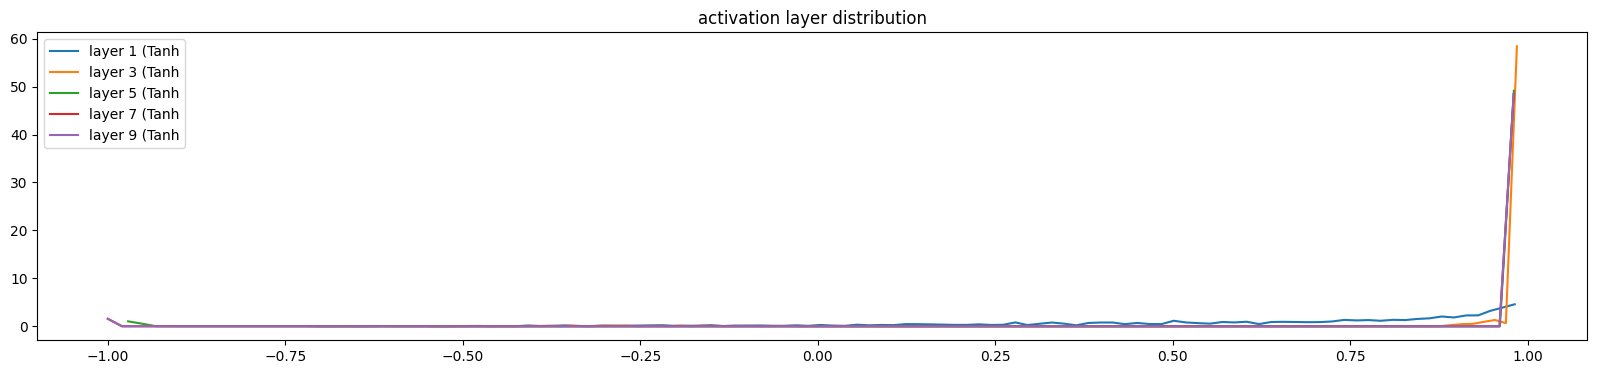

In [113]:
#Visualize Activations of Tanh layers with Histograms
plt.figure(figsize = (20,4)) #width/height of plot
legends = []
for i, layer in enumerate(layers[:-1]): #every layer except the last one
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation layer distribution')

In [ ]:
#1:28